# Bidirektionales LSTM
## Wichtige Informationen zu diesem Jupyter Notebook
In diesem Notebook wurde ein neuronales Netz implementiert und ausgewertet. Es handelt sich bei diesem Modell um ein bidirektionales LSTM. Um das vollständige Projekt zu erhalten, sollten Sie auf unserem GitHub - Repository nachschauen. Dort erhalten Sie weitere Informationen zu eigenen Packages/Modules und vor allem unseres README etc. Hier ist der Link zum Respository: https://github.com/levinsin/RUL-Prediction-CNN-BiLSTM

## Ergänzende Informationen
Dieses Notebook ist nicht dazu gedacht, eine vollständige und umfassende Beschreibung zu liefern. Eine vollständige Beschreibung wird durch die README.md auf unserem GitHub mitgeliefert. Viel Spaß beim Ausprobieren!

## Allgemeine Informationen
Im Laufe dieses Projekts wurden zwei neuronale Netze entwickelt und trainiert, ein bi-LSTM und ein CNN.

@Developer: Christoph Gahabka, Jonathan Remus und Levin Singler

# Bidirectional LSTM
## Important Information regarding this Jupyter Notebook
This notebook implements and evaluates a neural network based on a Bidirectional LSTM architecture. To access the complete project, please visit our GitHub repository. There, you will find additional details regarding licensing, requirements, and more.
Repository link: https://github.com/levinsin/RUL-Prediction-CNN-BiLSTM

## Supplementary Information
This notebook is not intended to provide a full and comprehensive project description. For detailed documentation, please refer to the README.md provided in our GitHub repository. Have fun exploring the model!

## General Information
Throughout this project, two distinct neural networks were developed and trained: a Bi-LSTM and a CNN.

@Developers: Christoph Gahabka, Jonathan Remus, and Levin Singler

### Imports

In [ ]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset

from config import (
    BATCH_SIZE,
    CHECKPOINT_LSTM_PATH,
    EPOCHS,
    FILENAME,
    LEARNING_RATE,
    LSTM_WIN_LEN,
    PATIENCE_SCHEDULER,
    PATIENCE_STOP,
    WEIGHT_DECAY,
)

### Scaler
scales the X-Matrix

In [ ]:
scaler = MinMaxScaler()

### Training Dataset
#### Init
Loading the data from .h5 file. The _dev data gets filtered and concenated to the matrix self.X.
The scaler scales the matrix. We clip the Y's to make sure that the AI concentrates on the smaller Y's. We don't want to waste any computing time for the AI to find differences on data with larger Y's. 125 is a experience value.

#### getitem
This for the training loop.

In [ ]:
class CMAPSSDataset(Dataset):
    def __init__(self, file_path, window_size=50):
        self.file_path = file_path
        self.window_size = window_size

        with h5py.File(file_path, "r") as f:
            # slicing
            X_s = np.array(f["X_s_dev"], dtype=np.float32)
            W = np.array(f["W_dev"], dtype=np.float32)
            T = np.array(f["T_dev"], dtype=np.float32)
            X_v = np.array(f["X_v_dev"], dtype=np.float32)
            A = np.array(f["A_dev"], dtype=np.float32)

            # training data
            self.X = np.concatenate([X_s, W, T, X_v, A], axis=1)
            self.X = scaler.fit_transform(self.X)

            self.y = np.array(f["Y_dev"], dtype=np.float32)
            self.y = np.clip(self.y, 0, 125)

        # normalization
        self.X = (self.X - self.X.min(axis=0)) / (
            self.X.max(axis=0) - self.X.min(axis=0) + 1e-6
        )

    def __len__(self):
        return len(self.X) - self.window_size

    def __getitem__(self, idx):
        window = self.X[idx : idx + self.window_size]
        target = self.y[idx + self.window_size]

        return torch.from_numpy(window), torch.from_numpy(target)

### Validation Dataset
This is similar to the training dataset -> just other slices

In [ ]:
class CMAPSSValSet:
    def __init__(self, file_path, window_size=50):
        self.file_path = file_path
        self.window_size = window_size

        with h5py.File(file_path, "r") as f:
            # slicing
            X_s_test = np.array(f["X_s_test"], dtype=np.float32)
            W_test = np.array(f["W_test"], dtype=np.float32)
            T_test = np.array(f["T_test"], dtype=np.float32)
            X_v_test = np.array(f["X_v_test"], dtype=np.float32)
            A_test = np.array(f["A_test"], dtype=np.float32)

            # validation data
            self.X_test = np.concatenate(
                [X_s_test, W_test, T_test, X_v_test, A_test], axis=1
            )
            self.X_test = scaler.fit_transform(self.X_test)

            self.y_test = np.array(f["Y_test"], dtype=np.float32)
            self.y_test = np.clip(self.y_test, 0, 125)

            self.unit_ids = A_test[:, 0].astype(int)

        # normalization
        self.X_test = (self.X_test - self.X_test.min(axis=0)) / (
            self.X_test.max(axis=0) - self.X_test.min(axis=0) + 1e-6
        )

    def __len__(self):
        return len(self.X_test) - self.window_size

    def __getitem__(self, idx):
        window = self.X_test[idx : idx + self.window_size]
        target = self.y_test[idx + self.window_size]

        unit_id = self.unit_ids[idx + self.window_size]

        return (
            torch.from_numpy(window),
            torch.from_numpy(target),
            torch.tensor(unit_id),
        )

### Initialization of datasets

In [ ]:
train_dataset = CMAPSSDataset(FILENAME, window_size=LSTM_WIN_LEN)
validation_dataset = CMAPSSValSet(FILENAME, window_size=LSTM_WIN_LEN)

## Bidirectional LSTM
### Init
A bidirectional LSTM reads data not only from left to right, it reads it in both directions. It can better understand the context.
Dropout_prob detains how many neurons get reseted every period.
### Attention net
self.attn_query is a vector which filters out important datapoints. Softmax calculates a weight betwenn 0 and 1. Context-Vector 'sums' up the important datapoints.
### FC-Layers
This is the neural network which is the decider. The linear layer combines the features, the norm layer norms the weights, the LeakyReLU is the activation function which lets some negative weights pass(dying neurons) and the dropout kills some connections to force the modell to generalize.

In [ ]:
class RUL_Predictor(nn.Module):
    def __init__(
        self, input_dim, hidden_dim, num_layers, output_dim=1, dropout_prob=0.2
    ):
        super(RUL_Predictor, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # filter layer
        self.lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers,
            batch_first=True,
            bidirectional=True,
        )

        # dropout layer
        self.lstm_dropout = nn.Dropout(dropout_prob)

        # attention vector
        self.attn_query = nn.Parameter(torch.randn(hidden_dim * 2, 1))

        # dense layer
        self.fc_layers = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim * 2),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.LeakyReLU(0.1),
            nn.Dropout(dropout_prob),
            nn.Linear(hidden_dim * 2, hidden_dim // 2),
            nn.LeakyReLU(0.1),
            nn.Linear(hidden_dim // 2, output_dim),
        )

    def attention_net(self, lstm_output):

        attn_weights = torch.tanh(torch.matmul(lstm_output, self.attn_query))

        # calculating prob vector
        attn_weights = torch.softmax(attn_weights, dim=1)

        context = torch.sum(attn_weights * lstm_output, dim=1)
        return context

    def forward(self, x):

        # LSTM layer
        lstm_out, _ = self.lstm(x)

        # attention net
        context = self.attention_net(lstm_out)

        # dense layer
        out = self.fc_layers(context)

        return out

### Early Stopping
If the model is on the way to overfit, the EarlyStopping class stops the training epochs. The counter is raised when the validation loss (+delta) is greater than the best loss. When counter is greater or equal to the patience, the process of the training loop gets stopped.

In [ ]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta

        self.counter = 0
        self.best_loss = float("inf")
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            print(f"EarlyStopping Counter: {self.counter} von {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

### Dataloader

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(
    validation_dataset, batch_size=BATCH_SIZE, shuffle=False
)

### Model Initialization
The class gets initialized. If we can train on the gpu, we train on the gpu. This explains the model.to(device)

In [ ]:
input_dim = train_dataset.X.shape[1]
model = RUL_Predictor(
    input_dim=input_dim, hidden_dim=32, num_layers=1, dropout_prob=0.4
)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

RUL_Predictor(
  (lstm): LSTM(46, 32, batch_first=True, bidirectional=True)
  (lstm_dropout): Dropout(p=0.4, inplace=False)
  (fc_layers): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=64, out_features=16, bias=True)
    (5): LeakyReLU(negative_slope=0.1)
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)

### Criterion
Error function
### Optimizer
The Adam algorithm is a fast optimizer. It is ideal for big datasets and complex models.
### Scheduler
Adjusts the weights and learning rate.

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(
    model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, "min", patience=PATIENCE_SCHEDULER, factor=0.5
)

early_stopper = EarlyStopping(patience=PATIENCE_STOP, min_delta=0.1)

## Training and validation loop
First of all, the models fits with the training dataset. After that, we test the model with the validation dataset.
In the meantime, we save the checkpoints in each epoch and the early stopper checks whether it should stop or not.

In [ ]:
train_losses = []
val_losses = []


for epoch in range(EPOCHS):
    # ---------- Training ----------

    model.train()
    epoch_loss = 0

    for batch_X, batch_y in train_loader:
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()

        # forward pass
        predictions = model(batch_X)

        # compute loss / cost
        loss = criterion(predictions, batch_y.view(-1, 1))

        # backward pass
        # compute gradients
        loss.backward()
        # update weights
        optimizer.step()

        # loss calculation
        epoch_loss += loss.item()

    # average train loss
    avg_train_loss = epoch_loss / len(train_loader)

    # learning rate scheduler updated
    scheduler.step(avg_train_loss)

    train_losses.append(avg_train_loss)

    # save model each epoch
    checkpoint = {
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "loss": loss.item(),
    }
    torch.save(
        checkpoint, f"{CHECKPOINT_LSTM_PATH}/checkpoint_epoch_{epoch}.pth"
    )

    # -------- Validation ---------

    model.eval()
    val_epoch_loss = 0

    with torch.no_grad():
        for batch_X, batch_y, _ in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            # prediction
            val_predictions = model(batch_X)

            # criterion calcs loss
            v_loss = criterion(val_predictions, batch_y.view(-1, 1))

            val_epoch_loss += v_loss.item()

    avg_val_loss = val_epoch_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(
        f"[{epoch + 1}|{EPOCHS}] Avg Loss: {avg_train_loss}, Val Loss: {avg_val_loss}"
    )

    # early stopper checks
    early_stopper(avg_val_loss)
    if early_stopper.early_stop:
        print("Stopping the training!")
        break


if input("Save it? ").lower() == "y":
    PATH = "models/Bi-LSTM/complete_models/n_cmapss_lstm_model.pth"
    torch.save(model.state_dict(), PATH)

[1|20] Avg Loss: 529.384902787514, Val Loss: 67.423454817155
[2|20] Avg Loss: 51.54339899906199, Val Loss: 46.85654642476065
[3|20] Avg Loss: 48.87618150837443, Val Loss: 35.92182163936398
[4|20] Avg Loss: 46.8056533536353, Val Loss: 17.35188622857814
[5|20] Avg Loss: 45.28752822240077, Val Loss: 35.425122601767214
EarlyStopping Counter: 1 von 9
[6|20] Avg Loss: 43.643209525975536, Val Loss: 31.867795099658416
EarlyStopping Counter: 2 von 9
[7|20] Avg Loss: 42.31717971752448, Val Loss: 21.97628090509138
EarlyStopping Counter: 3 von 9
[8|20] Avg Loss: 41.01980658653269, Val Loss: 23.272043749470146
EarlyStopping Counter: 4 von 9
[9|20] Avg Loss: 39.894439597240904, Val Loss: 36.2595515755293
EarlyStopping Counter: 5 von 9
[10|20] Avg Loss: 38.8514778268666, Val Loss: 23.599000949518697
EarlyStopping Counter: 6 von 9
[11|20] Avg Loss: 37.91732232435619, Val Loss: 37.28111434291309
EarlyStopping Counter: 7 von 9
[12|20] Avg Loss: 37.06371894985001, Val Loss: 25.573144285833514
EarlyStoppi

### Plotting the train and validation losses

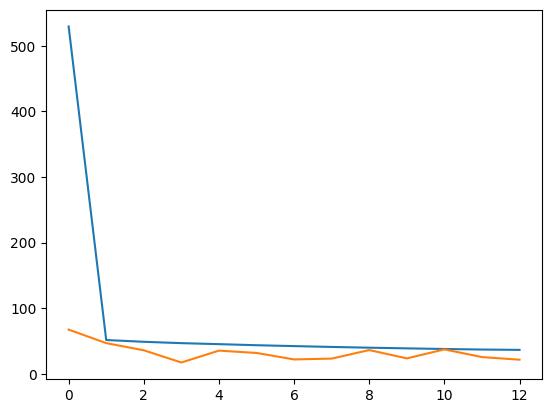

In [ ]:
plt.figure()
plt.plot(train_losses)
plt.plot(val_losses)

## Model testing
### Loop
We loop over the validation dataset and let the model predict. We save the original Y and X. The prediction is saved as well to be able to compare Y and Y_predicted. Afterwards, we have to scale our X's back -> see in the Dataset loading

In [ ]:
X_plot = []
Y_pred_plot = []
Y_plot = []
IDs_plot = []

model.eval()


with torch.no_grad():
    for batch_X, batch_y, batch_id in val_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        # prediction of model
        y_pred = model(batch_X)

        # reshaping of X for scaler
        X_2d = batch_X.cpu().numpy().reshape(batch_X.shape[0], -1)
        X_plot.append(X_2d[:, :46])

        # appending prediction and real Y
        Y_pred_plot.append(y_pred.cpu().numpy().reshape(y_pred.shape[0], -1))
        Y_plot.append(batch_y.cpu().numpy().reshape(batch_y.shape[0], -1))

        # appending the unit ids
        IDs_plot.append(batch_id.numpy())

X_plot = np.concatenate(X_plot, axis=0)
Y_plot = np.concatenate(Y_plot, axis=0)
Y_pred_plot = np.concatenate(Y_pred_plot, axis=0)
IDs_plot = np.concatenate(IDs_plot).flatten()

X_plot = scaler.inverse_transform(X_plot)

### Analyzing the whole dataset
A hexbin shows the number of datapoints in a field in a certain colour depending on the amount of datapoints in this field. It is ideal for a huge amount of datapoints. 

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

hb1 = ax1.hexbin(X_plot, Y_plot, gridsize=50, cmap="inferno", bins="log")
ax1.set_title("Realdaten")
ax1.set_xlabel("X")
ax1.set_ylabel("Echte Werte")
fig.colorbar(hb1, ax=ax1, label="Anzahl Punkte (log)")

hb2 = ax2.hexbin(X_plot, Y_pred_plot, gridsize=50, cmap="inferno", bins="log")
ax2.set_title("Prognosedaten")
ax2.set_xlabel("X")
ax2.set_ylabel("KI-Vorhersage")
fig.colorbar(hb2, ax=ax2, label="Anzahl Punkte (log)")

plt.tight_layout()
plt.show()

### Comparing Y and Y_predicted
If our model would be ideal, a first angle bisector is plotted. We only compare Y and Y_pred without the X.

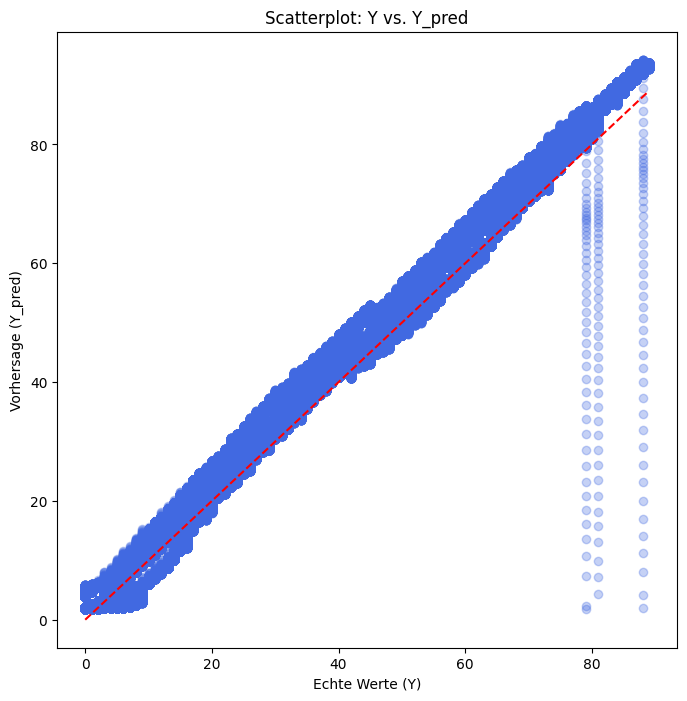

In [ ]:
unit_id = 7
mask = X_plot[:, 0].astype(int) == unit_id

Y_unit_true = Y_plot[mask].flatten()
Y_unit_pred = Y_pred_plot[mask].flatten()
time_steps = np.arange(len(Y_unit_true))

plt.figure(figsize=(8, 8))
plt.scatter(Y_plot, Y_pred_plot, alpha=0.3, color="royalblue")
plt.xlabel("Echte Werte (Y)")
plt.ylabel("Vorhersage (Y_pred)")
plt.title("Scatterplot: Y vs. Y_pred")
plt.plot([Y_plot.min(), Y_plot.max()], [Y_plot.min(), Y_plot.max()], "r--")
plt.show()

# Y and Y_pred in relation to the the cycles

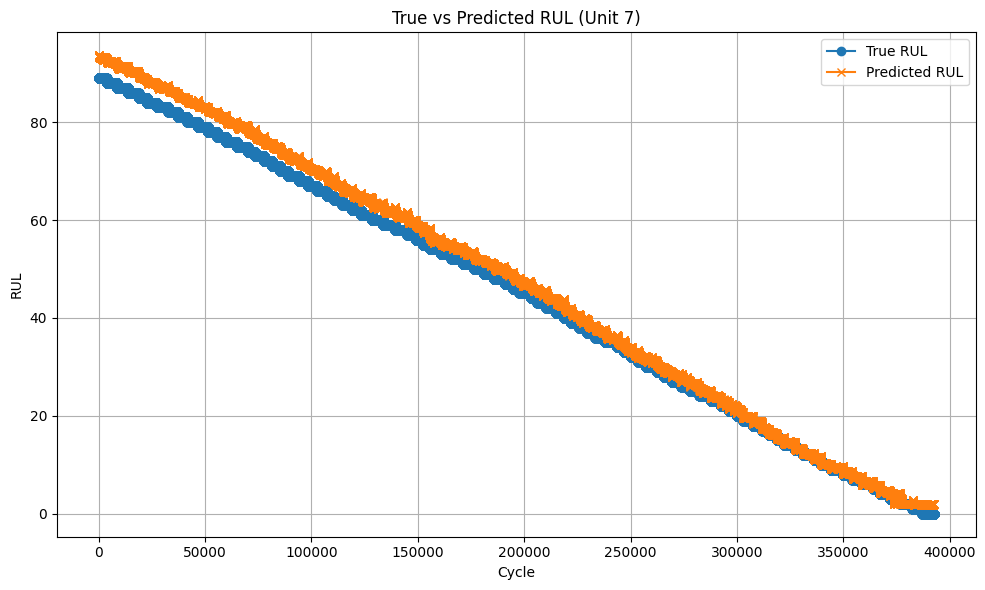

In [ ]:
unit_id = 7
mask = IDs_plot == unit_id

Y_unit_true = Y_plot[mask]
Y_unit_pred = Y_pred_plot[mask]
cycles = np.arange(1, len(Y_unit_true) + 1)

plt.figure(figsize=(10, 6))

plt.plot(
    cycles,
    Y_unit_true,
    label="True RUL",
    color="tab:blue",
    marker="o",
    linestyle="-",
)

plt.plot(
    cycles,
    Y_unit_pred,
    label="Predicted RUL",
    color="tab:orange",
    marker="x",
    linestyle="-",
)

plt.title(f"True vs Predicted RUL (Unit {unit_id})")
plt.xlabel("Cycle")
plt.ylabel("RUL")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()